In [1]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install pytorch-lightning --quiet

In [3]:
!pip install torchvision --quiet

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics import Accuracy

In [5]:
!pip install roboflow

from roboflow import Roboflow

rf = Roboflow(api_key="4Bh5rZ0ReMXinc4msNFY")
project = rf.workspace("ld").project("raabin-wbc-klasyfikacja")
dataset = project.version(2).download("folder")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to RAABIN-WBC---KLASYFIKACJA-2 in folder:: 100%|██████████| 6031/6031 [00:02<00:00, 2807.21it/s]


In [6]:
class ResNetBlock(nn.Module):
    def __init__(self, in_features, activation_function, subsample=False, out_features=-1):
        """
        A single ResNet block.
        
        Args:
            in_features: number of input features
            act_fn: activation function
            subsample: whether to subsample the input
            out_features: number of output features. If -1, use in_features.
        """

        super().__init__()
        if not subsample:
            out_features = in_features

        self.net = nn.Sequential(
            nn.Conv2d(in_features, out_features, kernel_size=3, stride=1 if not subsample else 2, padding=1, bias=False),
            nn.BatchNorm2d(out_features),
            activation_function,
            nn.Conv2d(out_features, out_features, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_features),
        )

        self.downsample = nn.Conv2d(in_features, out_features, kernel_size=1, stride=2) if subsample else None
        self.activation_function = activation_function

    def forward(self, x):
        z = self.net(x)
        if self.downsample is not None:
            x = self.downsample(x)
        out = z + x
        out = self.activation_function(out)
        return out
        

In [7]:
resnet_blocks_by_name = {
    "ResNetBlock": ResNetBlock,
}

act_fn_by_name = {
    "tanh": nn.Tanh,
    "relu": nn.ReLU,
    "leakyrelu": nn.LeakyReLU,
    "gelu": nn.GELU
}

In [8]:
from types import SimpleNamespace


class ResNet(nn.Module):

    def __init__(self,num_classes=5, num_blocks=[3,3,3], c_hidden=[16,32,64], 
    activation_function_name="relu", block_name="ResNetBlock", **kwargs):

        super().__init__()
        self.num_classes = num_classes
        self.hparams = SimpleNamespace(
            num_classes=num_classes,
            c_hidden=c_hidden,
            num_blocks=num_blocks,
            activation_function_name=activation_function_name,
            activation_function=act_fn_by_name[activation_function_name],
            block_class=resnet_blocks_by_name[block_name],
        )

        self._create_network()
        self._init_params()


    def _create_network(self):
        c_hidden = self.hparams.c_hidden

        self.input_net = nn.Sequential(
            nn.Conv2d(3, c_hidden[0], kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(c_hidden[0]),
            self.hparams.activation_function(),
        )

        blocks = []
        for block_idx, block_count in enumerate(self.hparams.num_blocks):
            for bc in range(block_count):
                subsample = (bc == 0) and (block_idx > 0)
                blocks.append(
                    self.hparams.block_class(
                        in_features=c_hidden[block_idx] if not subsample else c_hidden[block_idx - 1],
                        activation_function=self.hparams.activation_function(),
                        subsample=subsample,
                        out_features=c_hidden[block_idx],
                )
                )

        self.blocks = nn.Sequential(*blocks)
        
        self.output_net = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(c_hidden[-1], self.hparams.num_classes),
        )

    def _init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity=self.hparams.activation_function_name)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.input_net(x)
        x = self.blocks(x)
        x = self.output_net(x)
        return x

In [9]:
model_dict = {}

def create_model(model_name, model_hparams):
    if model_name in model_dict:
        return model_dict[model_name](**model_hparams)
    else:
        assert False, f"Unknown model name \"{model_name}\". Available models are: {str(model_dict.keys())}"

model_dict["ResNet"] = ResNet

In [10]:
import pytorch_lightning as pl

In [11]:
import os
import numpy as np
import random
from PIL import Image
from types import SimpleNamespace

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## PyTorch
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision import transforms

In [12]:
CHECKPOINT_PATH = "../checkpoints"

from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


In [13]:
class LcbsiModule(pl.LightningModule):
    def __init__(self, model_name, model_hparams, optimizer_name, optimizer_hparams):
        super().__init__()
        self.model = create_model(model_name, model_hparams)
        self.optimizer_name = optimizer_name
        self.optimizer_hparams = optimizer_hparams
        self.save_hyperparameters()
        self.loss_module = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        # We will support Adam or SGD as optimizers.
        if self.hparams.optimizer_name == "Adam":
            # AdamW is Adam with a correct implementation of weight decay (see here for details: https://arxiv.org/pdf/1711.05101.pdf)
            optimizer = optim.AdamW(
                self.parameters(), **self.hparams.optimizer_hparams)
        elif self.hparams.optimizer_name == "SGD":
            optimizer = optim.SGD(self.parameters(), **self.hparams.optimizer_hparams)
        else:
            assert False, f"Unknown optimizer: \"{self.hparams.optimizer_name}\""

        scheduler = optim.lr_scheduler.MultiStepLR(
            optimizer, milestones=[100, 150], gamma=0.1)
        
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (preds == labels).float().mean()
        self.log('test_acc', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        loss = self.loss_module(self.model(imgs), labels)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (preds == labels).float().mean()
        self.log('val_acc', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        loss = self.loss_module(self.model(imgs), labels)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (preds == labels).float().mean()
        self.log('test_acc', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        loss = self.loss_module(self.model(imgs), labels)
        self.log('test_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

    def load_from_checkpoint(self, checkpoint_path):
        self.load_state_dict(torch.load(checkpoint_path))

In [14]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from pathlib import Path


class LeukocytesDataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str = "data", batch_size: int = 32):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_classes = 5

        self.transform = transforms.Compose([
            transforms.Resize((124, 124)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def prepare_data(self):
        # download
        pass

    def setup(self, stage=None):
        train_transforms = self.transform
        val_transforms = self.transform

        # path to data, use pathlib module for cross-platform compatibility

        path_to_dataset = Path(self.data_dir)

        self.train_dataset = ImageFolder(path_to_dataset / "train", train_transforms)
        self.val_dataset = ImageFolder(path_to_dataset / "valid", val_transforms)
        self.test_dataset = ImageFolder(path_to_dataset / "test", val_transforms)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=4)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=4)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=4)

In [15]:
DATASET_DIRECTORY = "RAABIN-WBC---KLASYFIKACJA-2"

leukocytes_data_module = LeukocytesDataModule(data_dir=DATASET_DIRECTORY, batch_size=32)
leukocytes_data_module.setup()

In [16]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached urllib3-1.26.12-py2.py3-none-any.whl (140 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.6
    Uninstalling urllib3-1.26.6:
      Successfully uninstalled urllib3-1.26.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
roboflow 0.2.18 requires urllib3==1.26.6, but you have urllib3 1.26.12 which is incompatible.


In [17]:
from pytorch_lightning.loggers import WandbLogger
import wandb

wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: polejowska. Use `wandb login --relogin` to force relogin


True

In [18]:
wandb_logger = WandbLogger(project="lcbsi-resnet", entity="polejowska", log_model=True, save_dir="wandb")

Providing log_model=True requires wandb version >= 0.10.22 for logging associated model metadata.
Hint: Upgrade with `pip install --upgrade wandb`.


In [20]:
class ImagePredictionLogger(pl.callbacks.Callback):
    def __init__(self, val_samples, num_samples=32):
        super().__init__()
        self.num_samples = num_samples
        self.val_imgs, self.val_labels = val_samples
    
    def on_validation_epoch_end(self, trainer, pl_module):
        # Bring the tensors to CPU
        val_imgs = self.val_imgs.to(device=pl_module.device)
        val_labels = self.val_labels.to(device=pl_module.device)
        # Get model prediction
        logits = pl_module(val_imgs)
        preds = torch.argmax(logits, -1)
        # Log the images as wandb Image
        trainer.logger.experiment.log({
            "trainer examples":[wandb.Image(x, caption=f"Pred:{pred}, Label:{y}") 
                           for x, pred, y in zip(val_imgs[:self.num_samples], 
                                                 preds[:self.num_samples], 
                                                 val_labels[:self.num_samples])]
            })

In [21]:
valid_samples = next(iter(leukocytes_data_module.val_dataloader()))
wandb_logger.experiment.log({"examples": [wandb.Image(sample) for sample in valid_samples[0]]})

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
wandb: WARNING Path wandb/wandb/ wasn't writable, using system temp directory.


In [33]:
def train_model(model_name, logger, save_name=None, **kwargs):
    """
    Inputs:
        model_name - Name of the model you want to run. Is used to look up the class in "model_dict"
        save_name (optional) - If specified, this name will be used for creating the checkpoint and logging directory.
    """
    if save_name is None:
        save_name = model_name

      

    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, save_name),                          # Where to save models
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",                     # We run on a GPU (if possible)
                         devices=1,
                         logger=logger,
                         max_epochs=20,                                                                     # How many epochs to train for if no patience is set
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),  # Save the best checkpoint based on the maximum val_acc recorded. Saves only weights and not optimizer
                                    LearningRateMonitor("epoch"), ImagePredictionLogger(valid_samples)],                                           # Log learning rate every epoch
                         enable_progress_bar=True)              
    
    trainer.logger = wandb_logger

    model = LcbsiModule(model_name=model_name, **kwargs)

    trainer.fit(model, leukocytes_data_module)

    return model, trainer

In [34]:
model, trainer = train_model(model_name="ResNet",
                                                     logger=wandb_logger,
                                           model_hparams={"num_classes": 5,
                                                          "c_hidden": [16,32,64],
                                                          "num_blocks": [3,3,3],
                                                          "act_fn_name": "relu"},
                                           optimizer_name="SGD",
                                           optimizer_hparams={"lr": 0.1,
                                                              "momentum": 0.9,
                                                              "weight_decay": 1e-4}
                                          )

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
Checkpoint directory wandb/lcbsi-resnet/3ibndpwt/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type             | Params
-------------------------------------------------
0 | model       | ResNet           | 272 K 
1 | loss_module | CrossEntropyLoss | 0     
-------------------------------------------------
272 K     Trainable params
0         Non-trainable params
272 K     Total params
1.088     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [35]:
# model = LcbsiModule.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

# Test best model on validation and test set
val_result = trainer.test(model, dataloaders=leukocytes_data_module.val_dataloader(), verbose=False)
test_result = trainer.test(model, dataloaders=leukocytes_data_module.test_dataloader(), verbose=False)


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

KeyError: ignored

In [37]:
test_result

[{'test_acc_epoch': 0.03494176268577576, 'test_loss_epoch': 2.094904899597168}]

In [38]:
val_result

[{'test_acc_epoch': 0.034970857203006744,
  'test_loss_epoch': 2.080211877822876}]

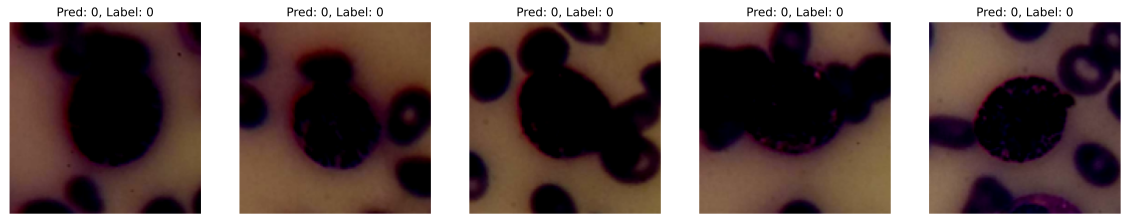

In [53]:
from torchvision.utils import make_grid
# run inference on cpu (port from gpu)
model = model.cpu()

# get a batch of validation data
imgs, labels = next(iter(leukocytes_data_module.val_dataloader()))

# get predictions
logits = model(imgs)
preds = torch.argmax(logits, -1)
# convert images to rgb for plotting
imgs = imgs.permute(0, 2, 3, 1)
imgs = imgs.numpy()
# plot images and labels
fig, ax = plt.subplots(1, 5, figsize=(20, 20))
for i in range(5):
    ax[i].imshow(imgs[i])
    ax[i].set_title(f"Pred: {preds[i]}, Label: {labels[i]}")
    ax[i].axis("off")

plt.show()

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


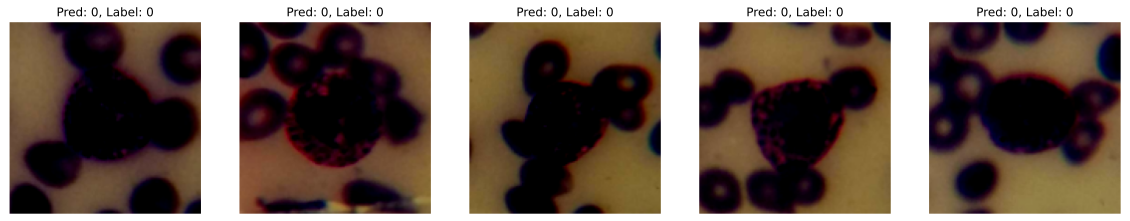

In [55]:
from torchvision.utils import make_grid
# run inference on cpu (port from gpu)
model = model.cpu()

# get a batch of validation data
imgs, labels = next(iter(leukocytes_data_module.test_dataloader()))

# get predictions
logits = model(imgs)
preds = torch.argmax(logits, -1)
# convert images to rgb for plotting
imgs = imgs.permute(0, 2, 3, 1)
imgs = imgs.numpy()
# plot images and labels
fig, ax = plt.subplots(1, 5, figsize=(20, 20))
for i in range(5):
    ax[i].imshow(imgs[i])
    ax[i].set_title(f"Pred: {preds[i]}, Label: {labels[i]}")
    ax[i].axis("off")

plt.show()